# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de Tenerife

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [39]:
def estudio_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')


    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color='blue')
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color='blue')
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=10),   train_s.index.union(test.index)[::10], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    


In [40]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

In [41]:
datos_Tenerife = datos_islas[datos_islas['isla'] == 'TENERIFE'].copy()

# Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_Tenerife = datos_Tenerife.sort_values(by='fecha')

# Añadimos como índice de los datos la fecha
datos_Tenerife.set_index('fecha', inplace=True)

# Variables 
variables_covid = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']
variables_atm = ['tmin', 'tmed', 'presMax']
variables = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST

# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos
# Modelo Univariable
datos_tenerife_arima_uni = datos_Tenerife['numero_casos']
datos_tenerife_arima_mult_covid = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_tenerife_arima_mult_atm = datos_Tenerife[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_tenerife_arima_total = datos_Tenerife.copy()

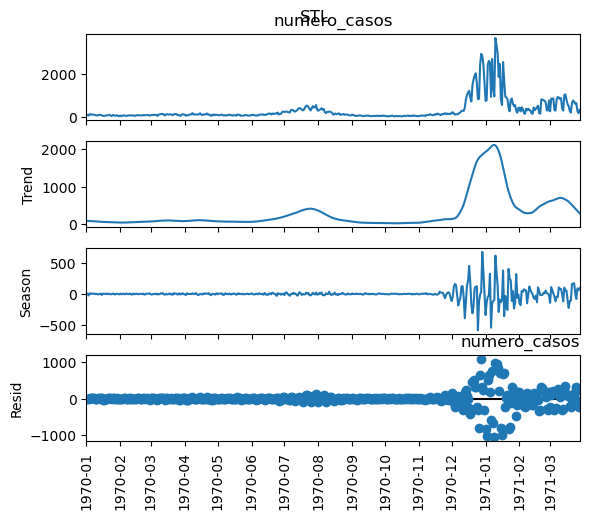

In [42]:
estudio_STL(datos_tenerife_arima_uni)

Realizamos la prueba de Dickey-Fuller para verificar si la serie temporal es estacionaria.

Esta prueba de 

In [6]:
visualizar_adf(datos_tenerife_arima_uni)

ADF p-value:0.009618252771198928


Podemos observar que el p valor es inferior al valor de significancia 0.05 por lo que la serie temporal ya es estacionaria y por lo tanto el valor d del modelo ARIMA es 0

Realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de p

<Figure size 1600x1000 with 0 Axes>

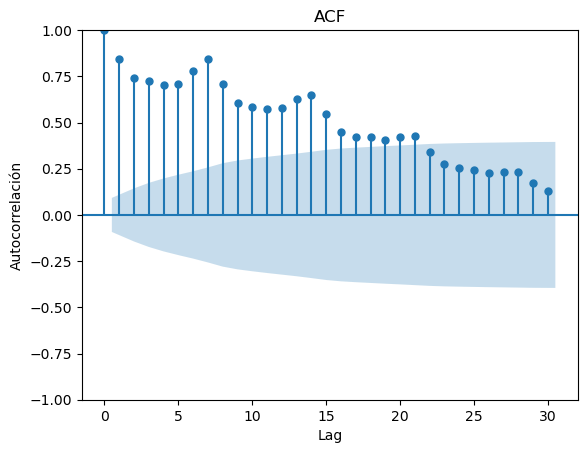

In [7]:
visualizar_acf(datos_tenerife_arima_uni, 30)

Realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de q

<Figure size 1600x600 with 0 Axes>

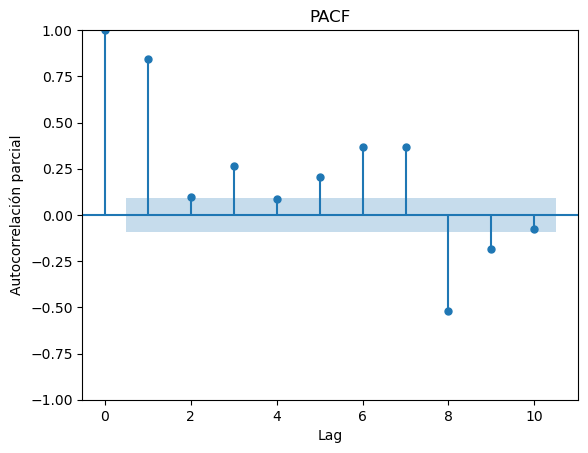

In [8]:
visualizar_pacf(datos_tenerife_arima_uni, 10)

Definimos los valores de p, d y q optimos obtenidos por los análisis realizados

In [9]:
# Parámetros del modelo ARIMA
p = 2 
d = 0
q = 6

# Modelo ARIMA univariable

In [10]:
# Conjuntos de entrenamiento y test
train = datos_tenerife_arima_uni.iloc[:len(datos_tenerife_arima_uni) - n_dias]
test =  datos_tenerife_arima_uni.iloc[len(datos_tenerife_arima_uni) - n_dias:]

In [11]:
#order=(p,d,q)

arima_tenerife = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_tenerife = arima_tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
visualizar_bic_aic(modelo_arima_tenerife)

BIC del modelo ARIMA: 6151.488052729505
AIC del modelo ARIMA: 6110.574953908728


In [13]:
pred = modelo_arima_tenerife.forecast(steps=10)
#pred = modelo_arima_tenerife.predict(start=test.index[0], end=test.index[-1])

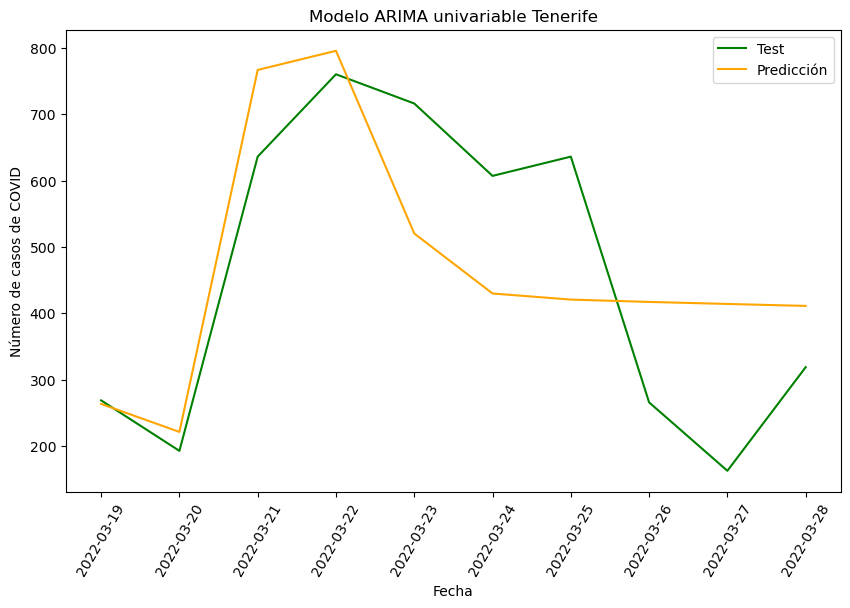

In [14]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable Tenerife'
visualizar_dif_pred_test(test, pred, '', tit)

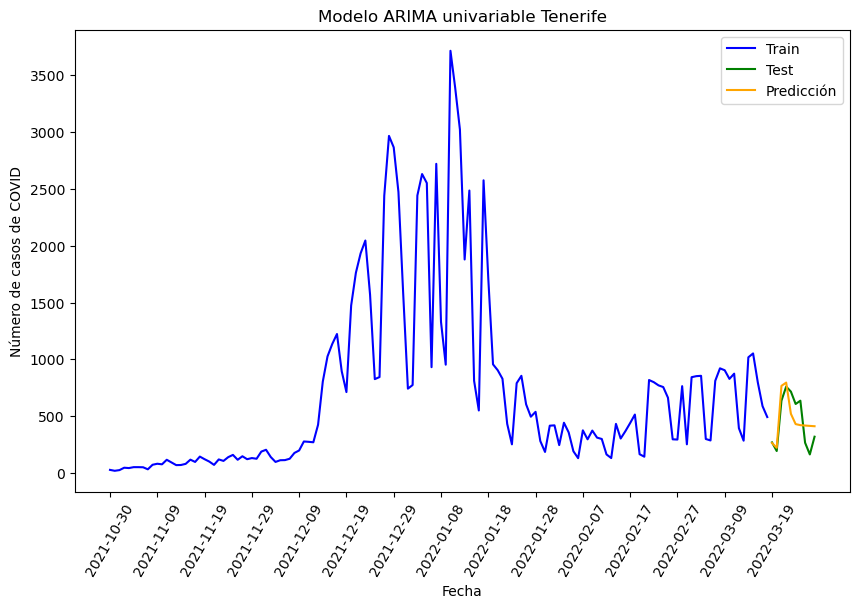

In [15]:
visualizar_historico(train, test, pred, '', 140, tit)

Para la evaluación del modelo se utilizará:
* MAE:
* MSE:
* RMSE:

In [17]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 22959.966834221057
Error absoluto medio (MAE) del modelo: 128.24293269162666
Raíz del error cuadrático medio (RMSE) del modelo: 151.52546595942565


# Modelo ARIMA multivariable con variables de pandemia

In [18]:
train = datos_tenerife_arima_mult_covid.iloc[:len(datos_tenerife_arima_mult_covid) - n_dias]
test =  datos_tenerife_arima_mult_covid.iloc[len(datos_tenerife_arima_mult_covid) - n_dias:]

In [19]:
#order=(p,d,q)
# Parámetros del modelo ARIMA

arima_tenerife = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_tenerife = arima_tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
pred = modelo_arima_tenerife.forecast(steps=10, exog=test[variables_covid])
#pred = modelo_arima_tenerife.predict(start=test.index[0], end=test.index[-1], exog=test[variables_covid])

In [21]:
visualizar_bic_aic(modelo_arima_tenerife)

BIC del modelo ARIMA: 5771.943021602757
AIC del modelo ARIMA: 5714.664683253669


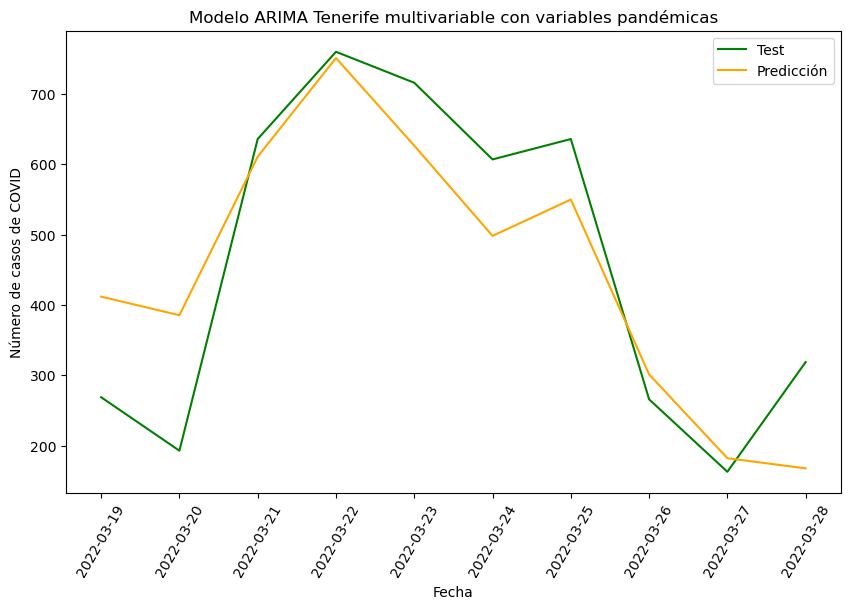

In [22]:
tit = 'Modelo ARIMA Tenerife multivariable con variables pandémicas'
visualizar_dif_pred_test(test, pred, objetivo, tit)

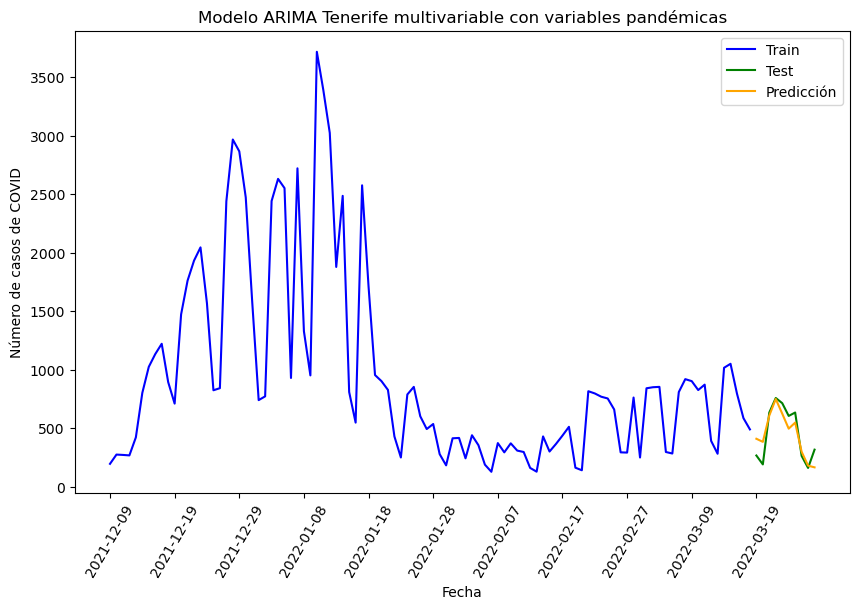

In [23]:
visualizar_historico(train, test, pred, objetivo, 100, tit)

In [24]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 10989.58560816789
Error absoluto medio (MAE) del modelo: 85.93801186033242
Raíz del error cuadrático medio (RMSE) del modelo: 104.83122439506224


# Modelo ARIMA multivariable con variables atmosféricas

In [25]:
train = datos_tenerife_arima_mult_atm.iloc[:len(datos_tenerife_arima_mult_atm) - n_dias]
test =  datos_tenerife_arima_mult_atm.iloc[len(datos_tenerife_arima_mult_atm) - n_dias:]

In [26]:
arima_tenerife = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_tenerife = arima_tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
visualizar_bic_aic(modelo_arima_tenerife)

BIC del modelo ARIMA: 6173.056991818861
AIC del modelo ARIMA: 6119.869963351851


In [28]:
pred = modelo_arima_tenerife.forecast(steps=10, exog=test[variables_atm])
#pred = modelo_arima_tenerife.predict(start=test.index[0], end=test.index[-1], exog=test[variables_covid])

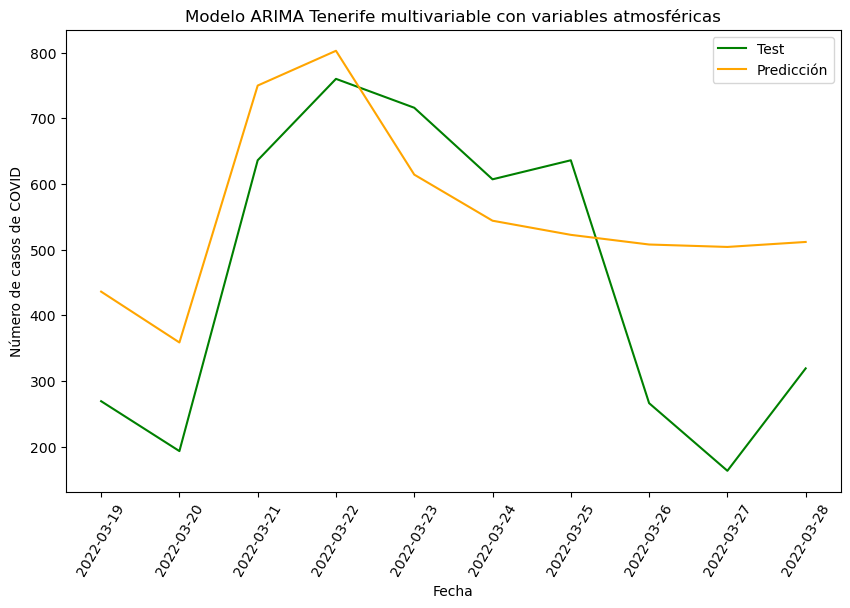

In [29]:
tit = 'Modelo ARIMA Tenerife multivariable con variables atmosféricas'

visualizar_dif_pred_test(test, pred, objetivo, tit)

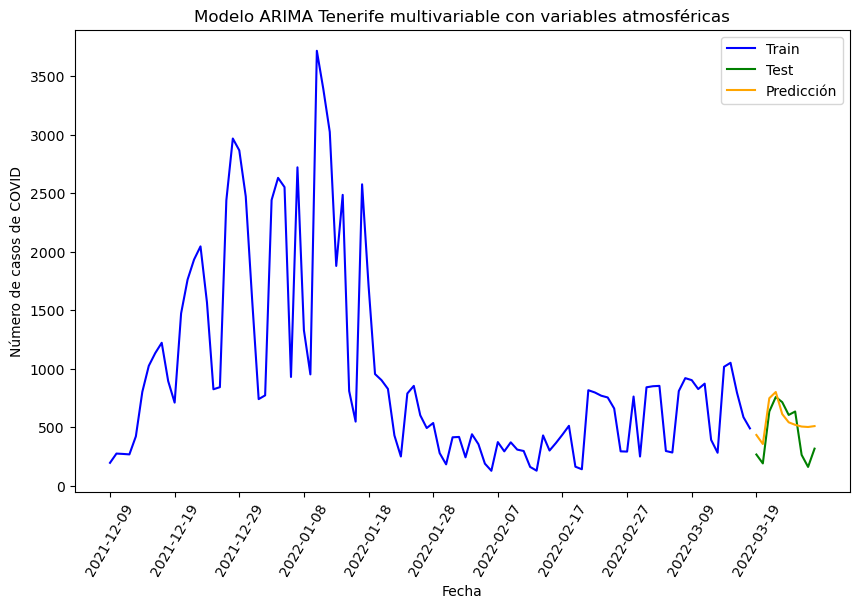

In [30]:
visualizar_historico(train, test, pred, objetivo, 100, tit)

In [31]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 30903.706605824154
Error absoluto medio (MAE) del modelo: 154.27173789581997
Raíz del error cuadrático medio (RMSE) del modelo: 175.7945010682193


# Modelo ARIMA multivariable con todas las variables

In [32]:
train = datos_tenerife_arima_total.iloc[:len(datos_tenerife_arima_total) - n_dias]
test =  datos_tenerife_arima_total.iloc[len(datos_tenerife_arima_total) - n_dias:]

In [33]:
arima_tenerife = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_tenerife = arima_tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
visualizar_bic_aic(modelo_arima_tenerife)

BIC del modelo ARIMA: 5789.276743942487
AIC del modelo ARIMA: 5719.724475947166


In [35]:
pred = modelo_arima_tenerife.forecast(steps=10, exog=test[variables])
#pred = modelo_arima_tenerife.predict(start=test.index[0], end=test.index[-1], exog=test[variables_covid])

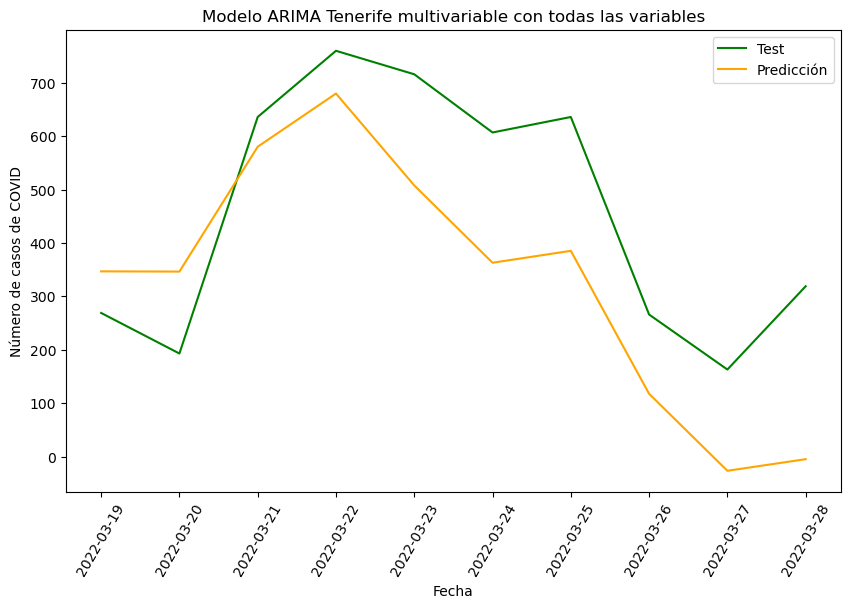

In [36]:
tit = 'Modelo ARIMA Tenerife multivariable con todas las variables'

visualizar_dif_pred_test(test, pred, objetivo, tit)

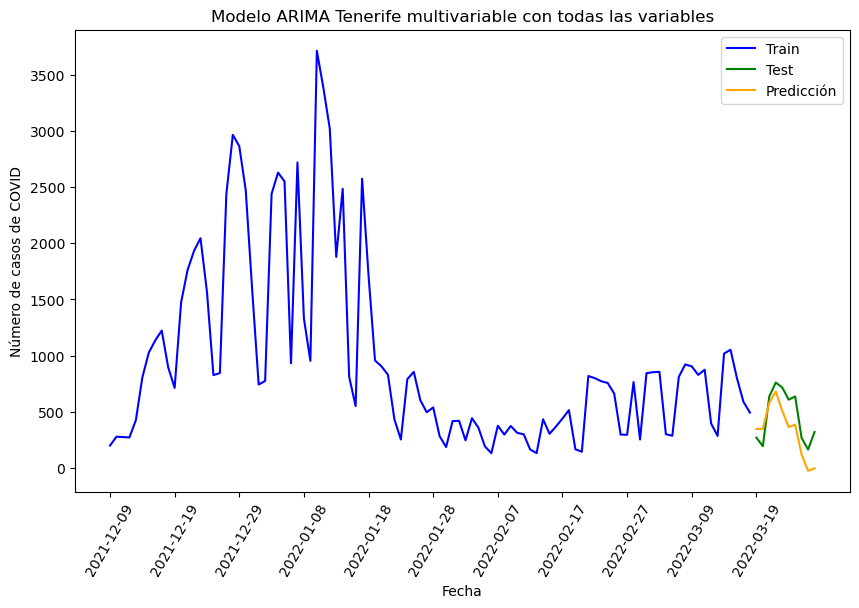

In [37]:
visualizar_historico(train, test, pred, objetivo, 100, tit)

In [38]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 36770.45983605031
Error absoluto medio (MAE) del modelo: 173.18842600340986
Raíz del error cuadrático medio (RMSE) del modelo: 191.75625110032348
